In [1]:
from skimage.io import imread
import numpy as np
from scipy.io import loadmat
from matplotlib import pyplot as plt
import time
from scipy.fftpack import dct, idct
import scipy as sp

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import os
os.chdir('/content/drive/MyDrive/Colab Notebooks/Image Processing/lez11_Inpainting_and_Spark')
os.getcwd()

'/content/drive/MyDrive/Colab Notebooks/Image Processing/lez11_Inpainting_and_Spark'

Load the image and rescale it in $[0,1]$

In [4]:
img = imread(f'./data/cameraman.png') / 255
#img = img[100:180,100:180]

imsz = img.shape

# patch size
p = 8

# number of elements in the patch
M = p ** 2

# radius of the search neighborhood
H = 25


Corrupt the image with white gaussian noise

In [5]:
sigma_noise = 20/255
noisy_img = img + np.random.normal(size=imsz) * sigma_noise

Compute the psnr of the noisy input

In [6]:
MSE = ((img - noisy_img)**2).mean()
psnr_noisy = 10 * np.log10(1/MSE)

Text(0.5, 1.0, 'Noisy image, PSNR = 22.10')

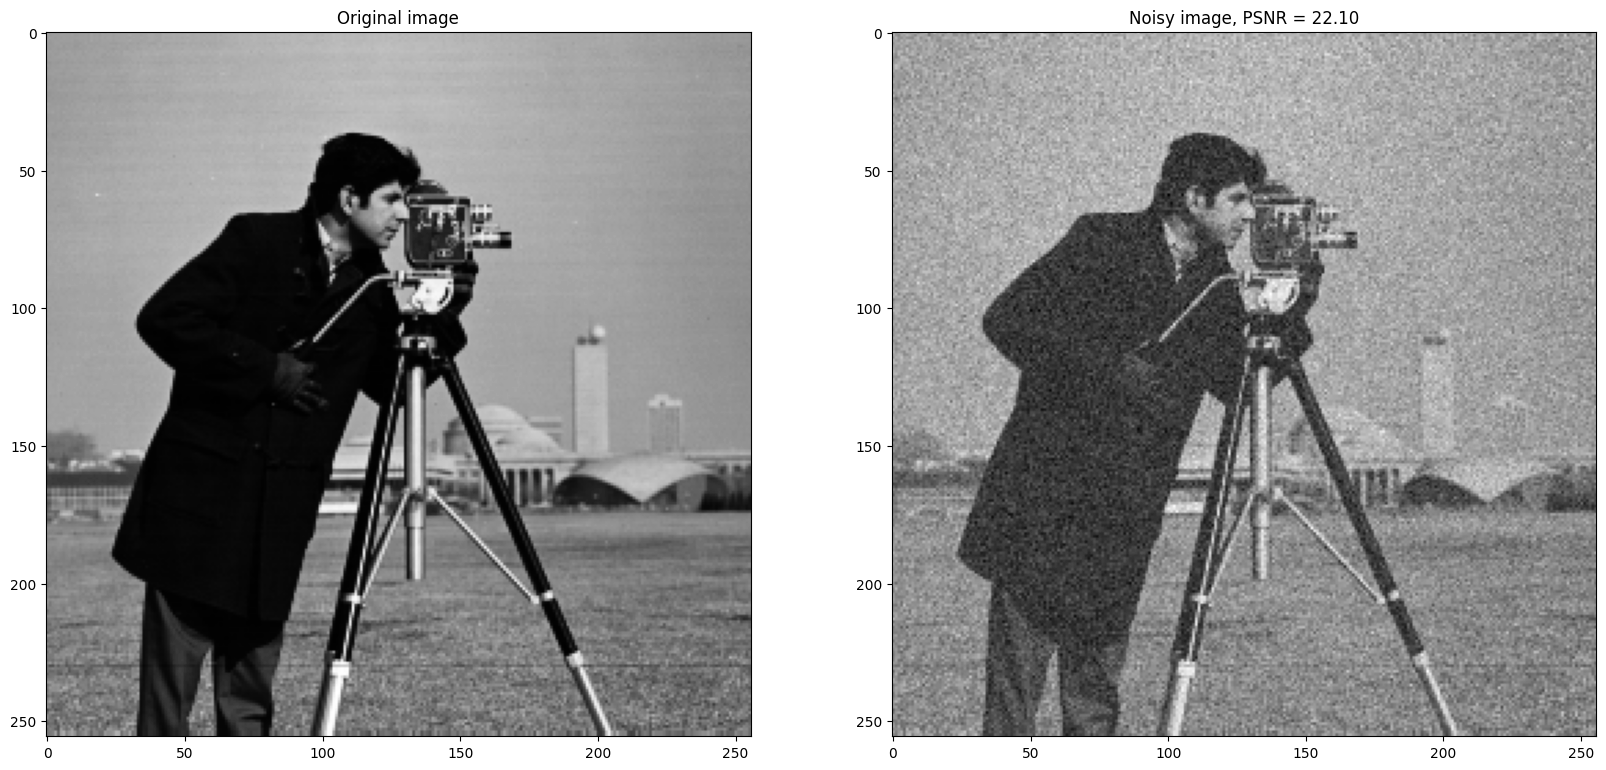

In [7]:
fig, ax = plt.subplots(1, 2, figsize=(20, 10))
ax[0].imshow(img, cmap='gray')
ax[0].set_title('Original image')

ax[1].imshow(noisy_img, cmap='gray')
ax[1].set_title(f'Noisy image, PSNR = {psnr_noisy:.2f}')


BM3D First part
--------------------
Set parameters and initialize the variables

In [8]:
# initialize the estimated image
img_hat = np.zeros_like(img)

# initialize the weight matrix
weights = np.zeros_like(img)

# define the step (=p for non overlapping paches)
STEP = 4 # STEP = 1 might be very time consuming, start with larger STEP

# max number of patches in the group
k = 16

# set the threshold for the Hard Thresholding
tau = 2.7 * sigma_noise 

# set the threshold for the distance to insert a patch in a group
epsilon = 0.05

# 2D-DCT dictionary
D = np.zeros((M, M))
cnt = 0
for i in range(p):
    for j in range(p):
        a = np.zeros((p,p))
        a[i,j] = 1
        D[:, cnt] = idct(idct(a.T, norm='ortho').T, norm='ortho').flatten()
        cnt = cnt + 1



Main loop

In [9]:
for i in range(0, imsz[0] - p + 1, STEP):
    for j in range(0, imsz[1] - p + 1, STEP):
        # extrach the patch with the top left corner at pixel (ii, jj)
        s = noisy_img[i:i+p,j:j+p].flatten()

        # Grouping
        G = []
        W = []
        pos_r = []
        pos_c = []
        for r in range(max(0, i - H), min(imsz[0] - p + 1, i + H + 1)):
          for c in range(max(0, j - H), min(imsz[1] - p + 1, j + H + 1)):
            # extract the patch
            z = noisy_img[r:r+p,c:c+p].flatten()

            # compute the distance with the reference patch
            d = (np.linalg.norm(s - z, ord=2)**2)/M
            
            if(d <= epsilon):
              G.append(z)
              W.append(d)
              pos_r.append(r)
              pos_c.append(c)
        if(len(G) > k):
          pos = np.argsort(W)[:k]
          G = [G[index] for index in pos]
          pos_r = [pos_r[index] for index in pos]
          pos_c = [pos_c[index] for index in pos]
        G = np.asarray(G).T

        # 1D-DCT dictionary
        A = np.zeros((G.shape[1], G.shape[1]))
        for s in range(G.shape[1]):
            # define the atom
            a = np.zeros(G.shape[1])
            a[s] = 1
            A[:, s] = idct(a, norm='ortho')

        # Collaborative Filtering
        G_w = np.dot(np.dot(D.T, G),A)
        for r in range(G_w.shape[0]):
          for c in range(G_w.shape[1]):
            if (r != 0 and c != 0):
              if (abs(G_w[r,c]) < tau):
                G_w[r,c] = 0 
        G_hat = np.dot(np.dot(D,G_w),A.T)
        if(np.count_nonzero(G_w) == 0):
          w = 1
        else:
          w = 1 / np.count_nonzero(G_w)

        # Aggregation
        for n in range(G_hat.shape[1]):
          # put the denoised patch into the estimated image using uniform weights
          img_hat[pos_r[n]:pos_r[n]+p, pos_c[n]:pos_c[n]+p] += G_hat[:,n].reshape((p,p)) * w
          # store the weight of the current patch in the weight matrix
          weights[pos_r[n]:pos_r[n]+p, pos_c[n]:pos_c[n]+p] += np.full((p, p), w)

img_hat = img_hat/weights

Compute the psnr of the estimated image

Text(0.5, 1.0, 'Estimated Image,\nPSNR = 29.36')

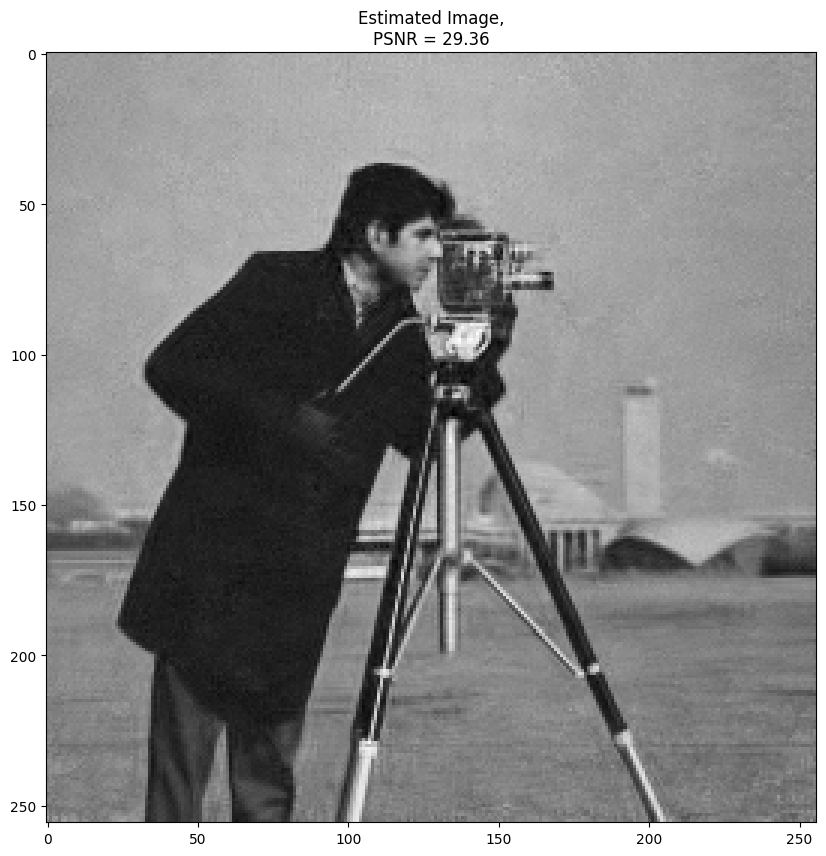

In [10]:
MSE = ((img - img_hat)**2).mean()
psnr_hat = 10 * np.log10(1/MSE)
plt.figure(figsize=(10,10))
plt.imshow(img_hat, cmap='gray')
plt.title(f'Estimated Image,\nPSNR = {psnr_hat:.2f}')


BM3D Second part
--------------------
Set parameters and initialize the variables

In [11]:
# initialize the estimated image
img_hat_final = np.zeros_like(img)

# initialize the weight matrix
weights = np.zeros_like(img)

# define the step (=p for non overlapping paches)
STEP = 4 # STEP = 1 might be very time consuming, start with larger STEP

# max number of patches in the group
k = 16

# set the threshold for the Hard Thresholding
tau = 2.7 * sigma_noise 

# set the threshold for the distance to insert a patch in a group
epsilon = 0.05

# 2D-DCT dictionary
D = np.zeros((M, M))
cnt = 0
for i in range(p):
    for j in range(p):
        a = np.zeros((p,p))
        a[i,j] = 1
        D[:, cnt] = idct(idct(a.T, norm='ortho').T, norm='ortho').flatten()
        cnt = cnt + 1



Main loop

In [12]:
for i in range(0, imsz[0] - p + 1, STEP):
    for j in range(0, imsz[1] - p + 1, STEP):
        # extrach the patch with the top left corner at pixel (ii, jj)
        s = img_hat[i:i+p,j:j+p].flatten()

        # Grouping
        G_y = []
        G_s = []
        W = []
        pos_r = []
        pos_c = []
        for r in range(max(0, i - H), min(imsz[0] - p + 1, i + H + 1)):
          for c in range(max(0, j - H), min(imsz[1] - p + 1, j + H + 1)):
            # extract the patch
            z = img_hat[r:r+p,c:c+p].flatten()

            # compute the distance with the reference patch
            d = (np.linalg.norm(s - z, ord=2)**2)/M
            
            if(d <= epsilon):
              G_y.append(z)
              G_s.append(noisy_img[r:r+p,c:c+p].flatten())
              W.append(d)
              pos_r.append(r)
              pos_c.append(c)
        if(len(G) > k):
          pos = np.argsort(W)[:k]
          G_y = [G_y[index] for index in pos]
          G_s = [G_s[index] for index in pos]
          pos_r = [pos_r[index] for index in pos]
          pos_c = [pos_c[index] for index in pos]
        G_y = np.asarray(G_y).T
        G_s = np.asarray(G_s).T

        # 1D-DCT dictionary
        A = np.zeros((G_y.shape[1], G_y.shape[1]))
        for s in range(G_y.shape[1]):
            # define the atom
            a = np.zeros(G_y.shape[1])
            a[s] = 1
            A[:, s] = idct(a, norm='ortho')

        # Collaborative Filtering
        G_yw = np.dot(np.dot(D.T, G_y),A)
        G_sw = np.dot(np.dot(D.T, G_s),A)
        G_wie = np.zeros(G_yw.shape)
        for r in range(G_yw.shape[0]):
          for c in range(G_yw.shape[1]):
            G_wie[r,c] = ((G_yw[r,c]**2) / ((G_yw[r,c]**2) + sigma_noise**2)) * G_sw[r,c]
        G_wie_hat = np.dot(np.dot(D,G_wie),A.T)
        if(np.count_nonzero(G_wie) == 0):
          w = 1
        else:
          w = 1 / np.count_nonzero(G_wie)

        # Aggregation
        for n in range(G_wie_hat.shape[1]):
          # put the denoised patch into the estimated image using uniform weights
          img_hat_final[pos_r[n]:pos_r[n]+p, pos_c[n]:pos_c[n]+p] += G_wie_hat[:,n].reshape((p,p)) * w
          # store the weight of the current patch in the weight matrix
          weights[pos_r[n]:pos_r[n]+p, pos_c[n]:pos_c[n]+p] += np.full((p, p), w)

img_hat_final = img_hat_final/weights

Compute the psnr of the estimated image

Text(0.5, 1.0, 'Estimated Image,\nPSNR = 29.87')

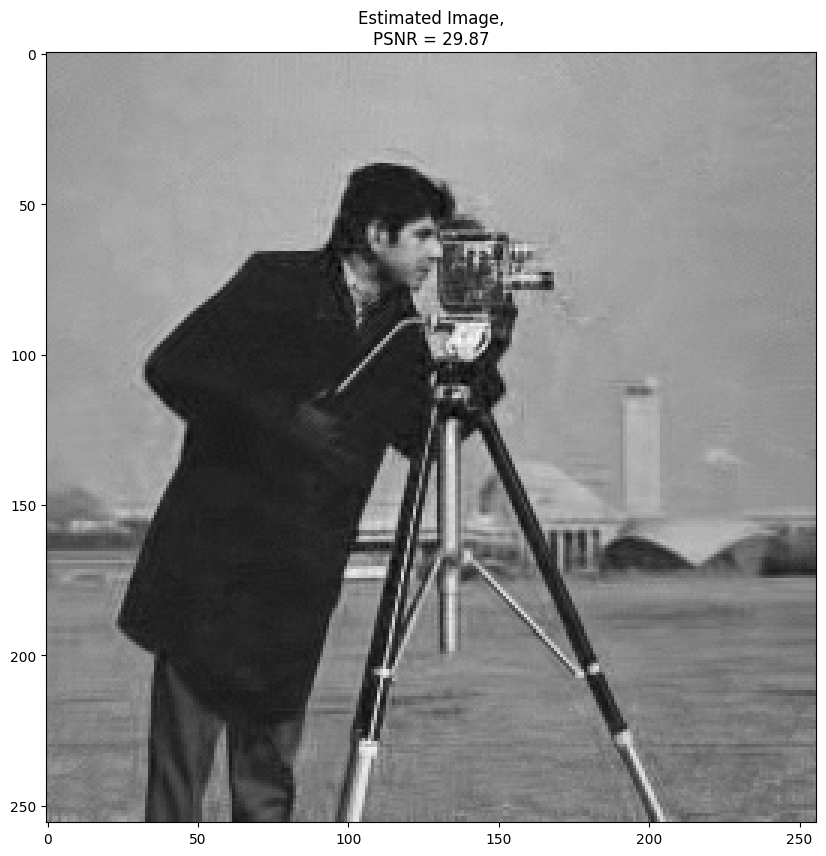

In [13]:
MSE = ((img - img_hat_final)**2).mean()
psnr_hat = 10 * np.log10(1/MSE)
plt.figure(figsize=(10,10))
plt.imshow(img_hat_final, cmap='gray')
plt.title(f'Estimated Image,\nPSNR = {psnr_hat:.2f}')
